# Detecting Ships using Satellite Images with Deep Learning    

## Importing libraries and modules needed for this notebook <a class="anchor"  id="h2.5"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import label

import gc
gc.enable()

## Exploring the data <a class="anchor"  id="h3"></a>

In [2]:
# Train and test directories
train_image_dir = '../input/airbus-ship-detection/train_v2'
test_image_dir = "../input/airbus-ship-detection/test_v2"

In [3]:
# Getting into train directory
train_images = os.listdir(train_image_dir)
train_images.sort()
print(f"Total of {len(train_images)} images in train directory.\nHere is how first five train_images looks like:- {train_images[:5]}")

Total of 192556 images in train directory.
Here is how first five train_images looks like:- ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg', '000194a2d.jpg', '0001b1832.jpg']


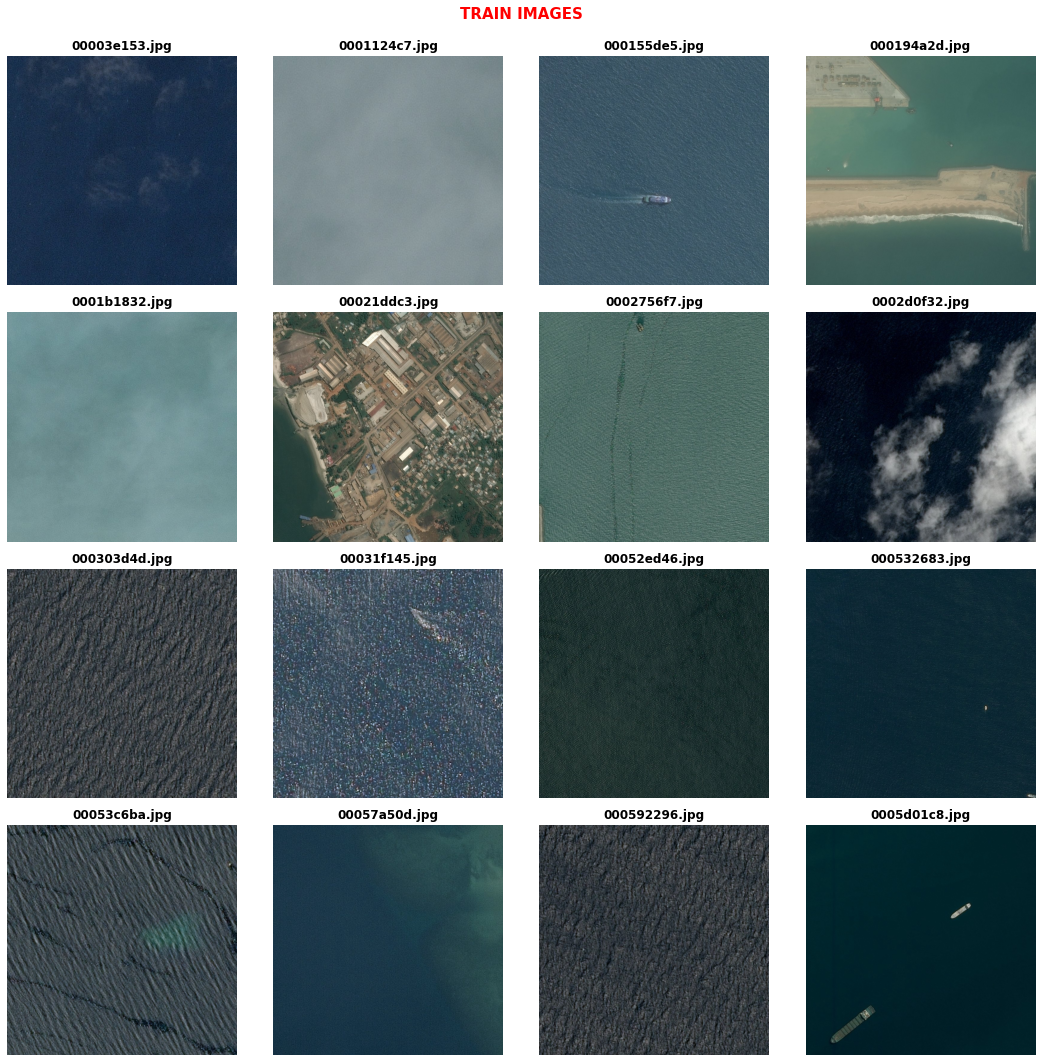

In [4]:
# Using for loop to generate different images to understand how data looks like
plt.figure(figsize=(15,15))
plt.suptitle('TRAIN IMAGES\n', weight = 'bold', fontsize = 15, color = 'r')
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(imread(train_image_dir + "/" + train_images[i]))
    plt.title(f"{train_images[i]}", weight = 'bold')
    plt.axis('off')
plt.tight_layout()

- So there are many images here that has no ships and few that does have one or multiple ships.

In [5]:
# Train ships segmented masks
masks = pd.read_csv("../input/airbus-ship-detection/train_ship_segmentations_v2.csv")
masks.head(10)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...

- Here, we can see some image ids are repeated. That is because we are given masks for each ship in one image.
- This simply means that number of ships in train image = total of repeated image ids in this masks data frame.
- NaN simply means that there are no ships in that image.
- We can combine this masks into one image for same image ids.
- Before that we need to make ourselves comfortable with this encoded format.

## Run Length Encoding (RLE) and Decoding <a class="anchor"  id="h4"></a>
- Run length encoding is a lossless compression.
- Lossless compression allows the original data to be perfectly reconstructed from the compressed data. 
- We simply run through the data and count how many times each data point is repeated without any breaks.
- Consider a small example below to grasp this idea:-

<img src = "https://img.api.video/1628663040-run-length.png?auto=format&dpr=1&fm=jpg&w=1370" width = 35%> 

- We tend to use RLE for data that contains long runs of the same value.
- If your data is complex without long runs then RLE can result in negative compression.
- There are many variations to it - run accross rows, run accross columns, run until pixel changes, etc.
- We also need to decompress the RLE data using run length decoding in order to use it. 

**Image example to understand it in a better way:-**    
- Let black pixels be 1 and white pixels be 0 in 10x10 image shown below.     

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcScKG8WJQhjdfUJU2-BBnj7UAgaoF3tK4CZYLRvSjcqjA6H-2BwIwFa3AXRb_Bt2WR5qi4&usqp=CAU" width = 35%>         

In [6]:
row_rle = ['10 1', 
           '4 1 2 0 4 1', 
           '3 1 4 0 3 1', 
           '2 1 6 0 2 1',
           '1 1 2 0 1 1 2 0 1 1 2 0 1 1', 
           '1 1 8 0 1 1', 
           '3 1 1 0 2 1 1 0 3 1', 
           '2 1 1 0 1 1 2 0 1 1 1 0 2 1', 
           '1 1 1 0 1 1 1 0 2 1 1 0 1 1 1 0 1 1', 
           '10 1',
           'Total']

pixels = [len(row.split(" ")) for row in row_rle if row != 'Total']
sum_pixels = np.array(pixels).sum()
pixels.append(sum_pixels)

data = {
    'Row - RLE' : row_rle,
    'Pixels' : pixels
}

rle_df = pd.DataFrame(data)
rle_df.index+=1
rle_df


Row - RLE  Pixels
1                                  10 1       2
2                           4 1 2 0 4 1       6
3                           3 1 4 0 3 1       6
4                           2 1 6 0 2 1       6
5           1 1 2 0 1 1 2 0 1 1 2 0 1 1      14
6                           1 1 8 0 1 1       6
7                   3 1 1 0 2 1 1 0 3 1      10
8           2 1 1 0 1 1 2 0 1 1 1 0 2 1      14
9   1 1 1 0 1 1 1 0 2 1 1 0 1 1 1 0 1 1      18
10                                 10 1       2
11                                Total      84

- Clearly we have compressed 100 data points into 84 data points.
- Some rows like 5, 8 and 14 gave more data points after encoding than it was in original.
- Reason being short runs as there were multiple breaks between black and white pixels.
- We can now apply this idea onto our data!

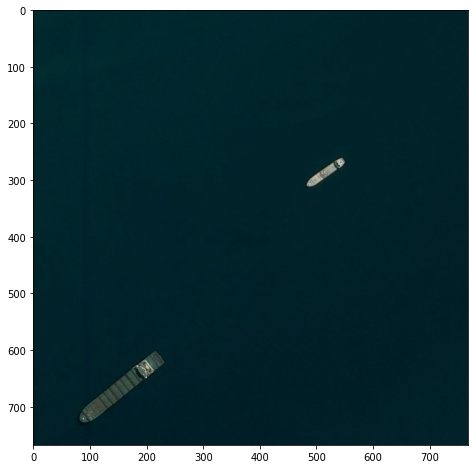

In [7]:
# Let us now see how it works for Image id:- 0005d01c8.jpg we have in the mask data frame

# Original image from training set
img_arr = imread(train_image_dir + '/' + '0005d01c8.jpg')
plt.figure(figsize=(15,8))
plt.imshow(img_arr)
plt.show()

In [8]:
img_arr.shape

(768, 768, 3)

In [9]:
# Filter out all 0005d01c8.jpg image ids and respective encoded data 
# 2 ships means 2 same image ids will be there!
rle_0 = masks.query('ImageId=="0005d01c8.jpg"')['EncodedPixels']
rle_0

29    56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...
30    365871 1 366638 3 367405 6 368173 7 368940 9 3...
Name: EncodedPixels, dtype: object

In [10]:
# Make a list of each mask shown above also visualise whats happening!
mask_lst, ct = [], 1
for mask in rle_0:
    print(f"Mask {ct} -\n{mask}\n\n")
    mask_lst.append(mask)
    ct+=1

Mask 1 -
56010 1 56777 3 57544 6 58312 7 59079 9 59846 11 60613 14 61380 16 62148 17 62915 19 63682 22 64449 24 65216 26 65984 27 66751 30 67518 32 68285 34 69052 36 69820 38 70587 40 71354 42 72121 42 72888 42 73656 42 74423 42 75190 42 75957 42 76724 42 77492 42 78259 42 79026 42 79793 42 80560 42 81328 42 82095 42 82862 42 83629 42 84396 42 85164 42 85931 42 86698 42 87465 42 88232 42 89000 42 89767 42 90534 42 91301 42 92068 42 92836 42 93603 42 94370 42 95137 42 95904 42 96672 42 97439 42 98206 42 98973 42 99740 42 100508 42 101275 42 102042 42 102809 42 103576 42 104344 42 105111 42 105878 42 106645 42 107412 42 108180 42 108947 42 109714 42 110481 42 111249 41 112016 42 112783 42 113550 42 114317 42 115085 41 115852 42 116619 42 117386 42 118153 42 118921 41 119688 42 120455 42 121222 42 121989 42 122757 41 123524 42 124291 42 125058 42 125825 42 126593 42 127360 42 128127 42 128894 42 129661 42 130429 42 131196 42 131963 42 132730 42 133497 42 134265 42 135032 42 135799 42 1365

In [11]:
# Split and Display how the first mask in the list looks like
split = mask_lst[0].split()
print(split)

['56010', '1', '56777', '3', '57544', '6', '58312', '7', '59079', '9', '59846', '11', '60613', '14', '61380', '16', '62148', '17', '62915', '19', '63682', '22', '64449', '24', '65216', '26', '65984', '27', '66751', '30', '67518', '32', '68285', '34', '69052', '36', '69820', '38', '70587', '40', '71354', '42', '72121', '42', '72888', '42', '73656', '42', '74423', '42', '75190', '42', '75957', '42', '76724', '42', '77492', '42', '78259', '42', '79026', '42', '79793', '42', '80560', '42', '81328', '42', '82095', '42', '82862', '42', '83629', '42', '84396', '42', '85164', '42', '85931', '42', '86698', '42', '87465', '42', '88232', '42', '89000', '42', '89767', '42', '90534', '42', '91301', '42', '92068', '42', '92836', '42', '93603', '42', '94370', '42', '95137', '42', '95904', '42', '96672', '42', '97439', '42', '98206', '42', '98973', '42', '99740', '42', '100508', '42', '101275', '42', '102042', '42', '102809', '42', '103576', '42', '104344', '42', '105111', '42', '105878', '42', '10664

- This data shows start_pixels and lenghts where we can think ship to exist in the original image.
- For example, 56777 3 shows that pixels 56777, 56778, 56779 contributes to the ship.
- Our target is to create an image with these pixels labeled as 1 and remaining as 0.
- This is how we can produce a mask for respective image.

In [58]:
# Grab all the starting pixels and lenghts and convert it into integers using numpy 
starts, lengths = [np.array(x, dtype = int) for x in (split[::2], split[1::2])]
starts, lengths

(array([ 56010,  56777,  57544,  58312,  59079,  59846,  60613,  61380,
         62148,  62915,  63682,  64449,  65216,  65984,  66751,  67518,
         68285,  69052,  69820,  70587,  71354,  72121,  72888,  73656,
         74423,  75190,  75957,  76724,  77492,  78259,  79026,  79793,
         80560,  81328,  82095,  82862,  83629,  84396,  85164,  85931,
         86698,  87465,  88232,  89000,  89767,  90534,  91301,  92068,
         92836,  93603,  94370,  95137,  95904,  96672,  97439,  98206,
         98973,  99740, 100508, 101275, 102042, 102809, 103576, 104344,
        105111, 105878, 106645, 107412, 108180, 108947, 109714, 110481,
        111249, 112016, 112783, 113550, 114317, 115085, 115852, 116619,
        117386, 118153, 118921, 119688, 120455, 121222, 121989, 122757,
        123524, 124291, 125058, 125825, 126593, 127360, 128127, 128894,
        129661, 130429, 131196, 131963, 132730, 133497, 134265, 135032,
        135799, 136566, 137333, 138101, 138868, 139635, 140402, 

In [ ]:
# Get the ending pixels. 
'''Examples:- 
56010 1 ---> Starts at 56010 and ends at 56010
56777 3 ---> Starts at 56777 and ends at 56779
57544 6 ---> Starts at 57544 and ends at 57549'''
ends = starts + lengths - 1
pd.DataFrame({
    'Starts' : starts,
    'Lengths' : lengths,
    'Ends' : ends
}).head(10)

In [ ]:
# Create 1s in place of these pixels and rest should be 0
img = np.zeros(768*768, dtype = np.uint8)
for start, end in zip(starts, ends):
    img[start:end+1] = 1

In [15]:
# Check how output looks
img[56776:56781] # Should output 0, 1 , 1, 1 ,0 as we know 56777, 56778, 56779 ---> 1 and 5676, 56780 ---> 0

array([0, 1, 1, 1, 0], dtype=uint8)

In [16]:
# Copy-Paste this idea for another ship in the image
split_1 = mask_lst[1].split()                                                                # Split the mask into start_pixels and lengths
starts, lengths = [np.array(x, dtype = int) for x in (split_1[0:][::2], split_1[1:][::2])]   # Generate arrays from only starts and lengths
ends = starts + lengths - 1                                                                  # Start pixel to end pixel will be start - 1 + length
img1 = np.zeros(768*768, dtype = np.uint8)                                                   # 1D array containing all zeros
for start, end in zip(starts, ends):                                                         # For each start to end pair
    img1[start:end+1] = 1                                                                    # Convert the values from 0 to 1

In [17]:
# Reshaping both the ship masks and combining it to form the final mask!
img = img.reshape(768, 768)
img1 = img1.reshape(768, 768)
final = img+img1
print(final, '\n\n', final.shape, '\n\n', final.ndim)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

 (768, 768) 

 2


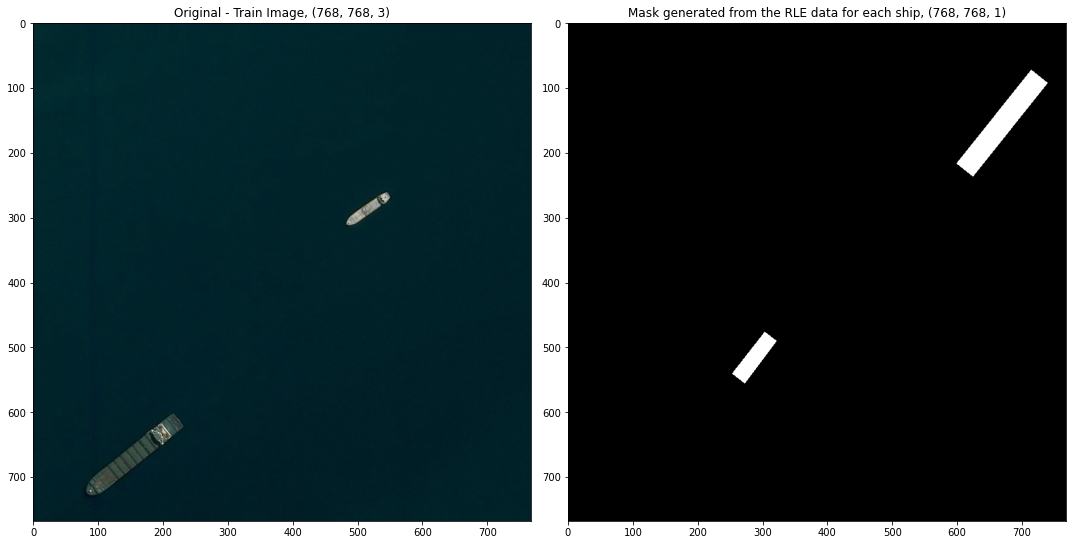

In [18]:
# Expand dimension of this array to have only 1 channel in the mask and visualise original and final mask
final = np.expand_dims(final, -1) # -1 means the last available dimenstion, in this case it is 2. Hence, on axis = 2 we will get 1.
original = imread(train_image_dir+'/'+train_images[15])
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title(f"Original - Train Image, {original.shape}")
plt.imshow(original)
plt.subplot(1, 2, 2)
plt.title(f"Mask generated from the RLE data for each ship, {final.shape}")
plt.imshow(final, cmap = "gray")
plt.tight_layout()
plt.show()

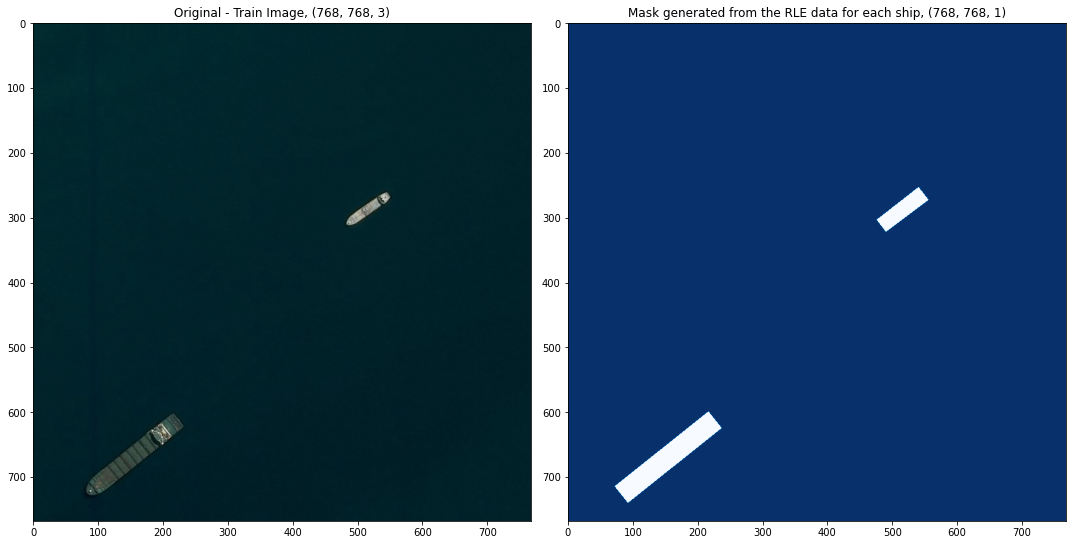

In [19]:
# Copy Paste the code from the prev cell with one change - Transpose!
img = img.reshape(768, 768).T     # Transpose the first ship mask
img1 = img1.reshape(768, 768).T   # Transpose the second ship mask
final = img+img1                  # Generate the final mask with two ships 
final = np.expand_dims(final, -1) 
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title(f"Original - Train Image, {original.shape}")
plt.imshow(original)
plt.subplot(1, 2, 2)
plt.title(f"Mask generated from the RLE data for each ship, {final.shape}")
plt.imshow(final, cmap = "Blues_r")
plt.tight_layout()
plt.show()

- So this is how the EncodedPixels data for one image id looks like!
- We can build a function that can quickly generate such masks for all the EncodedPixels wrt to its ImageId.

In [20]:
# Define functions to do these tasks for all the training images
def rle_decode(mask_rle, shape=(768,768)):
    '''
    Input arguments -
    mask_rle: Mask of one ship in the train image
    shape: Output shape of the image array
    '''
    s = mask_rle.split()                                                               # Split the mask of each ship that is in RLE format
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]     # Get the start pixels and lengths for which image has ship
    ends = starts + lengths - 1                                                        # Get the end pixels where we need to stop
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)                                  # A 1D vec full of zeros of size = 768*768
    for lo, hi in zip(starts, ends):                                                   # For each start to end pixels where ship exists
        img[lo:hi+1] = 1                                                               # Fill those values with 1 in the main 1D vector
    '''
    Returns -
    Transposed array of the mask: Contains 1s and 0s. 1 for ship and 0 for background
    '''
    return img.reshape(shape).T                                                       

def masks_as_image(in_mask_list):
    '''
    Input - 
    in_mask_list: List of the masks of each ship in one whole training image
    '''
    all_masks = np.zeros((768, 768), dtype = np.int16)                                 # Creating 0s for the background
    for mask in in_mask_list:                                                          # For each ship rle data in the list of mask rle 
        if isinstance(mask, str):                                                      # If the datatype is string
            all_masks += rle_decode(mask)                                              # Use rle_decode to create one mask for whole image
    '''
    Returns - 
    Full mask of the training image whose RLE data has been passed as an input
    '''
    return np.expand_dims(all_masks, -1)

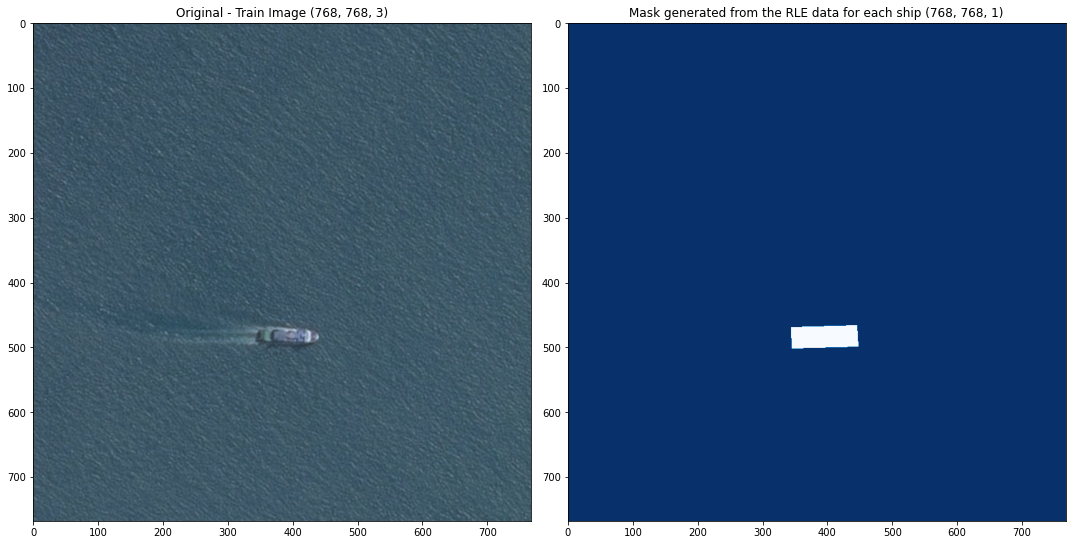

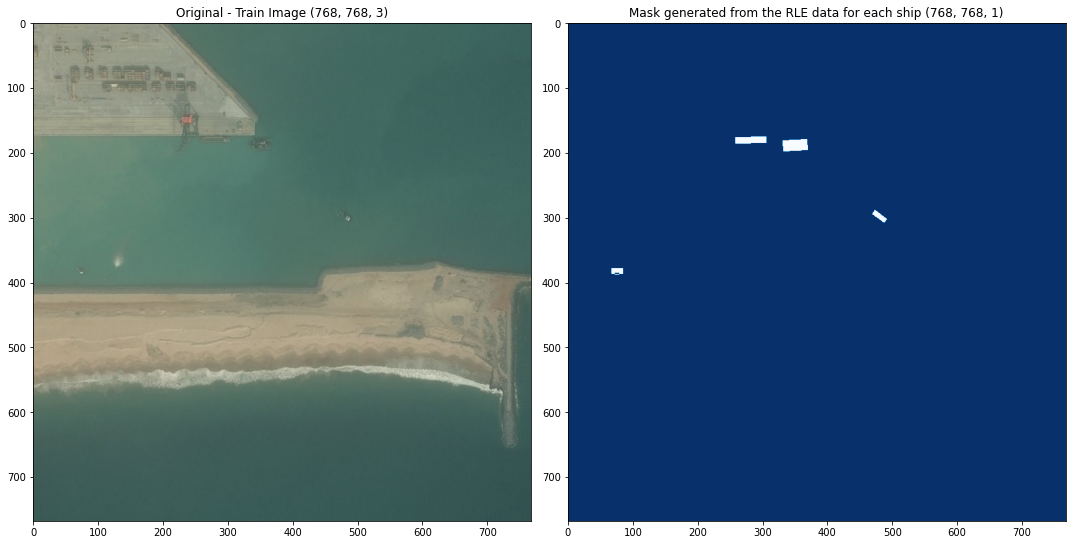

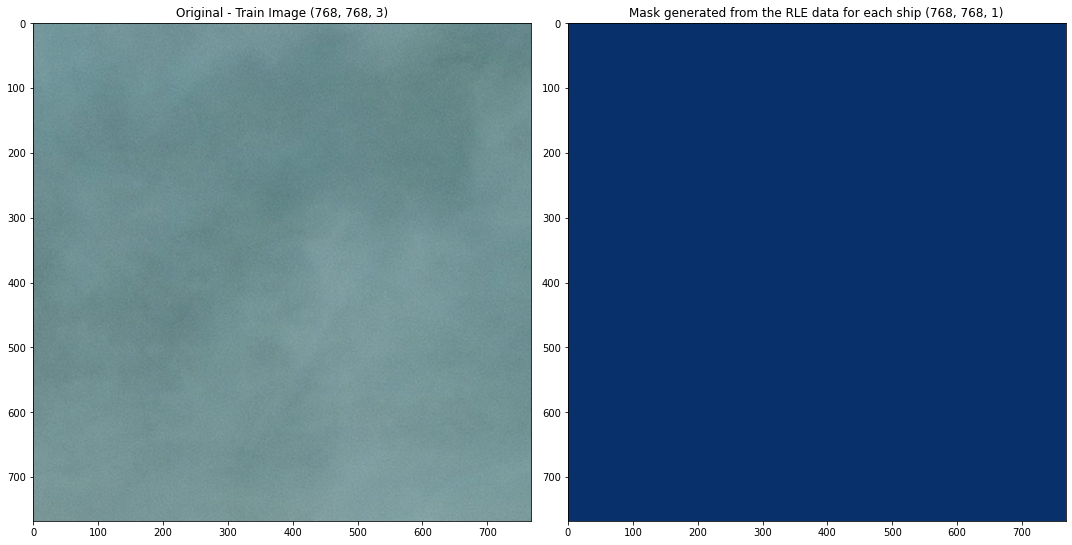

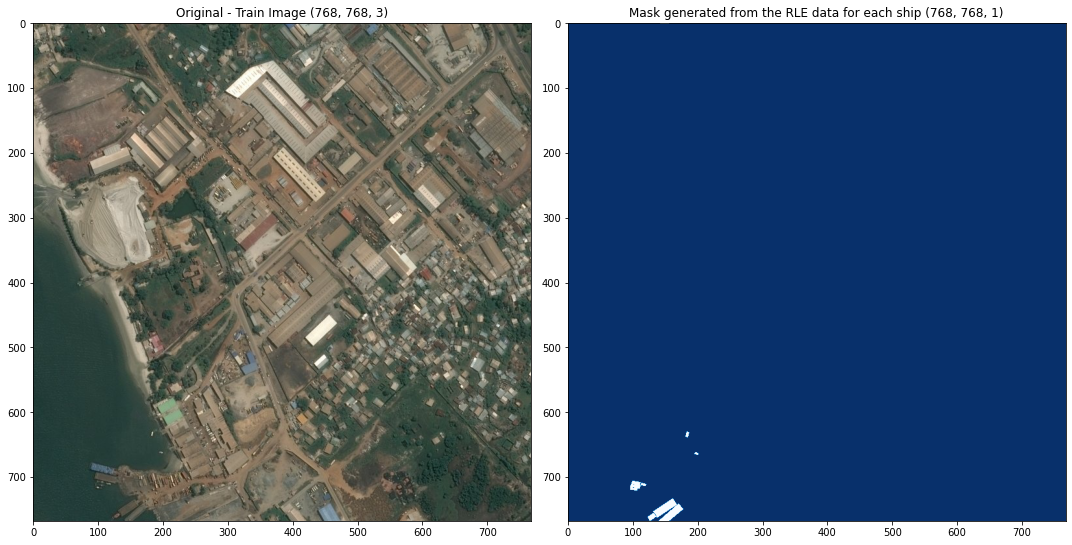

In [21]:
for num in [3, 4, 5, 6]:
    rle_0 = masks.query(f'ImageId=="{train_images[num-1]}"')['EncodedPixels']
    img_0 = masks_as_image(rle_0)
    original = imread(train_image_dir+"/"+train_images[num-1])
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.title(f"Original - Train Image {original.shape}")
    plt.imshow(original)
    plt.subplot(1, 2, 2)
    plt.title(f"Mask generated from the RLE data for each ship {final.shape}")
    plt.imshow(img_0, cmap = "Blues_r")
    plt.tight_layout()
    plt.show()

- We have succesfully constructed some functions that will take in the rle data and convert it into mask!
- We can now begin with spliting the data into train and validation.

## Preparing Train and Validation Data <a class="anchor"  id="h5"></a>

In [22]:
'''Note that NaN values in the EncodedPixels are of float type and everything else is a string type'''   

# Add a new feature to the masks data frame named as ship. If Encoded pixel in any row is a string, there is a ship else there isn't. 
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
masks.head(9)

ImageId                                      EncodedPixels  ships
0  00003e153.jpg                                                NaN      0
1  0001124c7.jpg                                                NaN      0
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      1
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      1
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...      1
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...      1
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...      1
8  0001b1832.jpg                                                NaN      0

In [23]:
# Making a new data frame with unique image ids where we are summing up the ship counts
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index() 
unique_img_ids.index+=1 # Incrimenting all the index by 1
unique_img_ids.head()

ImageId  ships
1  00003e153.jpg      0
2  0001124c7.jpg      0
3  000155de5.jpg      1
4  000194a2d.jpg      5
5  0001b1832.jpg      0

In [24]:
# Adding two new features to unique_img_ids data frame. If ship exists in image, val is 1 else 0. And it's vec form
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids.head()

ImageId  ships  has_ship
1  00003e153.jpg      0       0.0
2  0001124c7.jpg      0       0.0
3  000155de5.jpg      1       1.0
4  000194a2d.jpg      5       1.0
5  0001b1832.jpg      0       0.0

In [25]:
# Check the size of the files. Will take some time to run as there are loads of files!!!
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024)
'''os.stat is used to get status of the specified path. Here, st_size represents size of the file in bytes. Converting it into kB!'''

'os.stat is used to get status of the specified path. Here, st_size represents size of the file in bytes. Converting it into kB!'

In [26]:
# We can get rid of any images whose size is less than 35 Kb. As some of the files are corrupted! 
unique_img_ids[unique_img_ids.file_size_kb<35].head()

ImageId  ships  has_ship  file_size_kb
85    001bfb70a.jpg      0       0.0     22.796875
359   0080bd6a5.jpg      0       0.0     14.327148
819   011589d1f.jpg      0       0.0     20.317383
1434  01df54887.jpg      0       0.0     16.492188
2342  0318fc519.jpg      0       0.0     13.289062

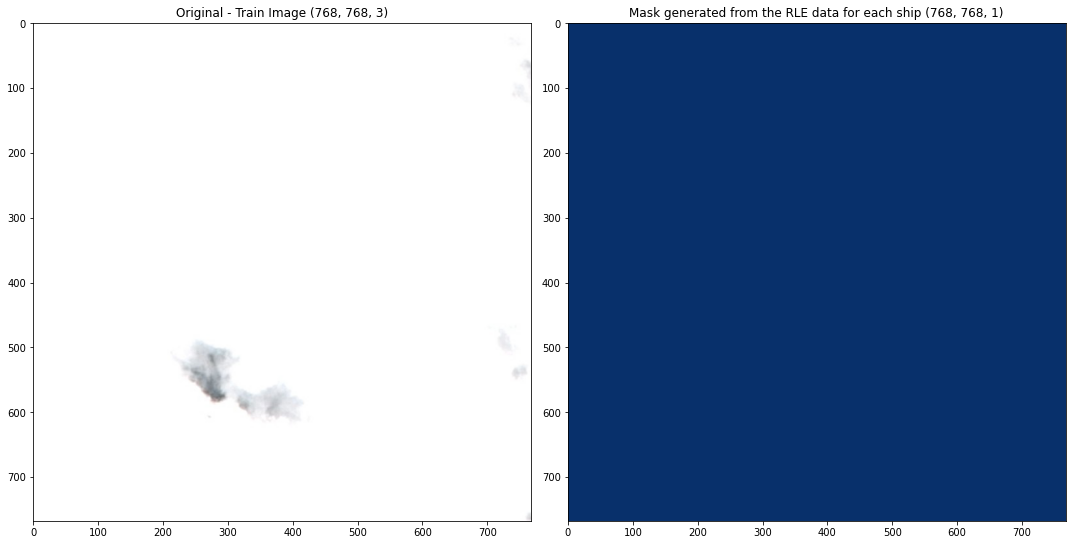

In [27]:
rle_0 = masks.query(f'ImageId=="0318fc519.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
original = imread(train_image_dir+"/"+'0318fc519.jpg')
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title(f"Original - Train Image {original.shape}")
plt.imshow(original)
plt.subplot(1, 2, 2)
plt.title(f"Mask generated from the RLE data for each ship {final.shape}")
plt.imshow(img_0, cmap = "Blues_r")
plt.tight_layout()
plt.show()

In [28]:
# Keep the files whose size > 35 kB
unique_img_ids = unique_img_ids[unique_img_ids.file_size_kb > 35]
unique_img_ids.head()

ImageId  ships  has_ship  file_size_kb
1  00003e153.jpg      0       0.0    128.944336
2  0001124c7.jpg      0       0.0     76.059570
3  000155de5.jpg      1       1.0    147.625977
4  000194a2d.jpg      5       1.0     75.221680
5  0001b1832.jpg      0       0.0     95.627930

In [29]:
# Also, retrive the old masks data frame
masks.drop(['ships'], axis=1, inplace=True)
masks.index+=1 
masks.head()

ImageId                                      EncodedPixels
1  00003e153.jpg                                                NaN
2  0001124c7.jpg                                                NaN
3  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
4  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
5  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

- Now, its the time to use the train_test_split.
- Stratify to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

In [30]:
# Train - Test split
from sklearn.model_selection import train_test_split                   
train_ids, valid_ids = train_test_split(unique_img_ids, test_size = 0.3, stratify = unique_img_ids['ships'])

In [31]:
# Create train data frame
train_df = pd.merge(masks, train_ids)

# Create test data frame
valid_df = pd.merge(masks, valid_ids)

In [32]:
print("There are ~")
print(train_df.shape[0], 'training masks,')
print(valid_df.shape[0], 'validation masks.')

There are ~
162047 training masks,
69439 validation masks.


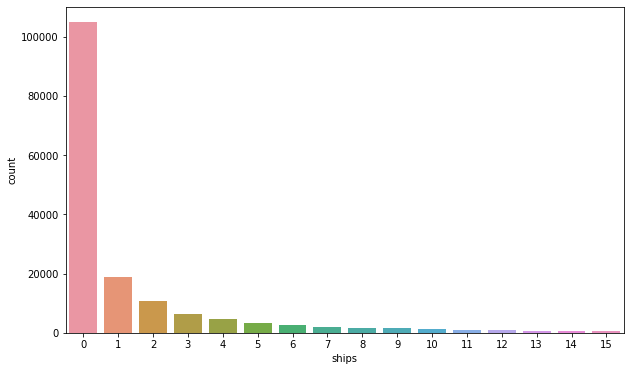

In [33]:
# Visualise the ship counts
plt.figure(figsize=(10, 6))
sns.countplot(train_df.ships)
plt.show()

- Oh!! Very huge imbalance in the data...
- We need to have a better balanced data!!!

## Random Undersampling to generate a better balanced data to work with

In [34]:
# Clipping the max value of grouped_ship_count to be 7, minimum to be 0
train_df['grouped_ship_count'] = train_df.ships.map(lambda x: (x+1)//2).clip(0,7)

In [35]:
# Check
train_df.grouped_ship_count.value_counts()

0    104837
1     29713
2     10744
3      5995
4      3772
5      2710
6      2155
7      2121
Name: grouped_ship_count, dtype: int64

#### Difference between head(n) and sample(n) in pandas
- df.head(n) returns only top n data from the df
- df.sample(n) returns random n data from the df

In [36]:
# Top 10 data
train_df.head(10)

ImageId                                      EncodedPixels  ships  \
0  0001124c7.jpg                                                NaN      0   
1  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1   
2  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      5   
3  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      5   
4  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...      5   
5  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...      5   
6  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...      5   
7  0001b1832.jpg                                                NaN      0   
8  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...      9   
9  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...      9   

   has_ship  file_size_kb  grouped_ship_count  
0       0.0     76.059570                   0  
1       1.0    147.625977                   1  
2       1.0     75.221680                   3  
3       1.0     75.221680                   3  
4       1.0     75.221680                   3  
5       1.0     75.221680                   3  
6       1.0     75.221680                   3  
7       0.0     95.627930                   0  
8       1.0    242.910156                   5  
9       1.0    242.910156                   5

In [37]:
# Random 10 data
train_df.sample(10)

ImageId                                      EncodedPixels  \
32318   334d1f602.jpg  398310 1 399076 4 399843 5 400609 8 401376 10 ...   
31071   31649d616.jpg                                                NaN   
56007   588becdd3.jpg                                                NaN   
62728   630fedfb4.jpg                                                NaN   
7012    0ad9efc2f.jpg  263756 2 264524 5 265291 9 266059 11 266827 14...   
41273   417e21a87.jpg                                                NaN   
113285  b2fad247c.jpg                                                NaN   
35860   3919d0c64.jpg  107546 5 108304 15 109067 20 109835 20 110603 ...   
86804   8965cef69.jpg                                                NaN   
154549  f451eb6f5.jpg                                                NaN   

        ships  has_ship  file_size_kb  grouped_ship_count  
32318       3       1.0    109.724609                   2  
31071       0       0.0    192.108398                   0  
56007       0       0.0    108.832031                   0  
62728       0       0.0     84.595703                   0  
7012        6       1.0    108.873047                   3  
41273       0       0.0     97.239258                   0  
113285      0       0.0    204.511719                   0  
35860       1       1.0    106.463867                   1  
86804       0       0.0    191.906250                   0  
154549      0       0.0    176.738281                   0

In [38]:
# Random Under-Sampling ships
def sample_ships(in_df, base_rep_val=1500):
    '''
    Input Args:
    in_df - dataframe we want to apply this function
    base_val - random sample of this value to be taken from the data frame
    '''
    if in_df['ships'].values[0]==0:                                                 
        return in_df.sample(base_rep_val//3)  # Random 1500//3 = 500 samples taken whose ship count is 0 in an image 
    else:                                 
        return in_df.sample(base_rep_val)    # Random 1500 samples taken whose ship count is not 0 in an image

In [39]:
# Creating groups of ship counts and applying the sample_ships functions to randomly undersample the ships
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df.grouped_ship_count.value_counts() # In each group we have total of 1500 ships except 0 as we have decreased it even more to 500

1    1500
2    1500
3    1500
4    1500
5    1500
6    1500
7    1500
0     500
Name: grouped_ship_count, dtype: int64

In [40]:
# Explaining what we just did if still not clear
for i in range(8):
    df_val_counts = balanced_train_df[balanced_train_df.grouped_ship_count==i].ships.value_counts()
    print(f"Data frame for grouped ship count = {i}:-\n{df_val_counts}\nSum of Values:- {df_val_counts.values.sum()}\n\n")


Data frame for grouped ship count = 0:-
0    500
Name: ships, dtype: int64
Sum of Values:- 500


Data frame for grouped ship count = 1:-
1    979
2    521
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 2:-
3    863
4    637
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 3:-
5    817
6    683
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 4:-
7    783
8    717
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 5:-
9     860
10    640
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 6:-
11    781
12    719
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 7:-
14    522
13    499
15    479
Name: ships, dtype: int64
Sum of Values:- 1500




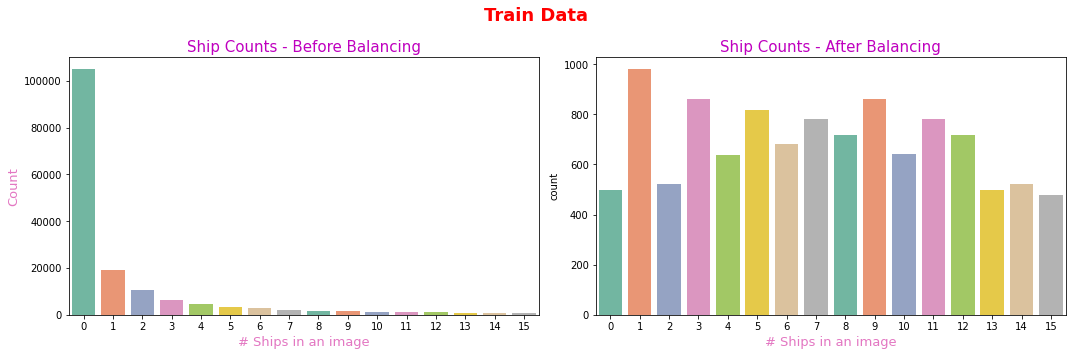

In [41]:
plt.figure(figsize = (15, 5))
plt.suptitle("Train Data", fontsize = 18, color = 'r', weight = 'bold')
plt.subplot(1, 2, 1)
import seaborn as sns
sns.countplot(train_df.ships, palette = 'Set2')
plt.title("Ship Counts - Before Balancing", color = 'm', fontsize = 15)
plt.ylabel("Count", color = 'tab:pink', fontsize = 13)
plt.xlabel("# Ships in an image", color = 'tab:pink', fontsize = 13)
plt.subplot(1, 2, 2)
sns.countplot(balanced_train_df.ships, palette = 'Set2')
plt.title("Ship Counts - After Balancing", color = 'm', fontsize = 15)
plt.xlabel("# Ships in an image", color = 'tab:pink', fontsize = 13)
plt.tight_layout()

In [42]:
# Parameters
BATCH_SIZE = 4                 # Train batch size
EDGE_CROP = 16                 # While building the model
NB_EPOCHS = 5                  # Training epochs
GAUSSIAN_NOISE = 0.1           # To be used in a layer in the model
UPSAMPLE_MODE = 'SIMPLE'       # SIMPLE ==> UpSampling2D, else Conv2DTranspose
NET_SCALING = None             # Downsampling inside the network                        
IMG_SCALING = (1, 1)           # Downsampling in preprocessing
VALID_IMG_COUNT = 400          # Valid batch size
MAX_TRAIN_STEPS = 200          # Maximum number of steps_per_epoch in training

In [43]:
# Image and Mask Generator
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    '''
    Inputs -
    in_df - data frame on which the function will be applied
    batch_size - number of training examples in one iteration
    '''
    all_batches = list(in_df.groupby('ImageId'))                             # Group ImageIds and create list of that dataframe
    out_rgb = []                                                             # Image list
    out_mask = []                                                            # Mask list
    while True:                                                              # Loop for every data
        np.random.shuffle(all_batches)                                       # Shuffling the data
        for c_img_id, c_masks in all_batches:                                # For img_id and msk_rle in all_batches
            rgb_path = os.path.join(train_image_dir, c_img_id)               # Get the img path
            c_img = imread(rgb_path)                                         # img array
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)         # Create mask of rle data for each ship in an img
            out_rgb += [c_img]                                               # Append the current img in the out_rgb / img list
            out_mask += [c_mask]                                             # Append the current mask in the out_mask / mask list
            if len(out_rgb)>=batch_size:                                     # If length of list is more or equal to batch size then
                yield np.stack(out_rgb)/255.0, np.stack(out_mask)            # Yeild the scaled img array (b/w 0 and 1) and mask array (0 for bg and 1 for ship)
                out_rgb, out_mask=[], []                                     # Empty the lists to create another batch

In [44]:
# Generate train data 
train_gen = make_image_gen(balanced_train_df)

# Image and Mask
train_x, train_y = next(train_gen)

# Print the summary
print(f"train_x ~\nShape: {train_x.shape}\nMin value: {train_x.min()}\nMax value: {train_x.max()}")
print(f"\ntrain_y ~\nShape: {train_y.shape}\nMin value: {train_y.min()}\nMax value: {train_y.max()}")

train_x ~
Shape: (4, 768, 768, 3)
Min value: 0.0
Max value: 1.0

train_y ~
Shape: (4, 768, 768, 1)
Min value: 0
Max value: 1


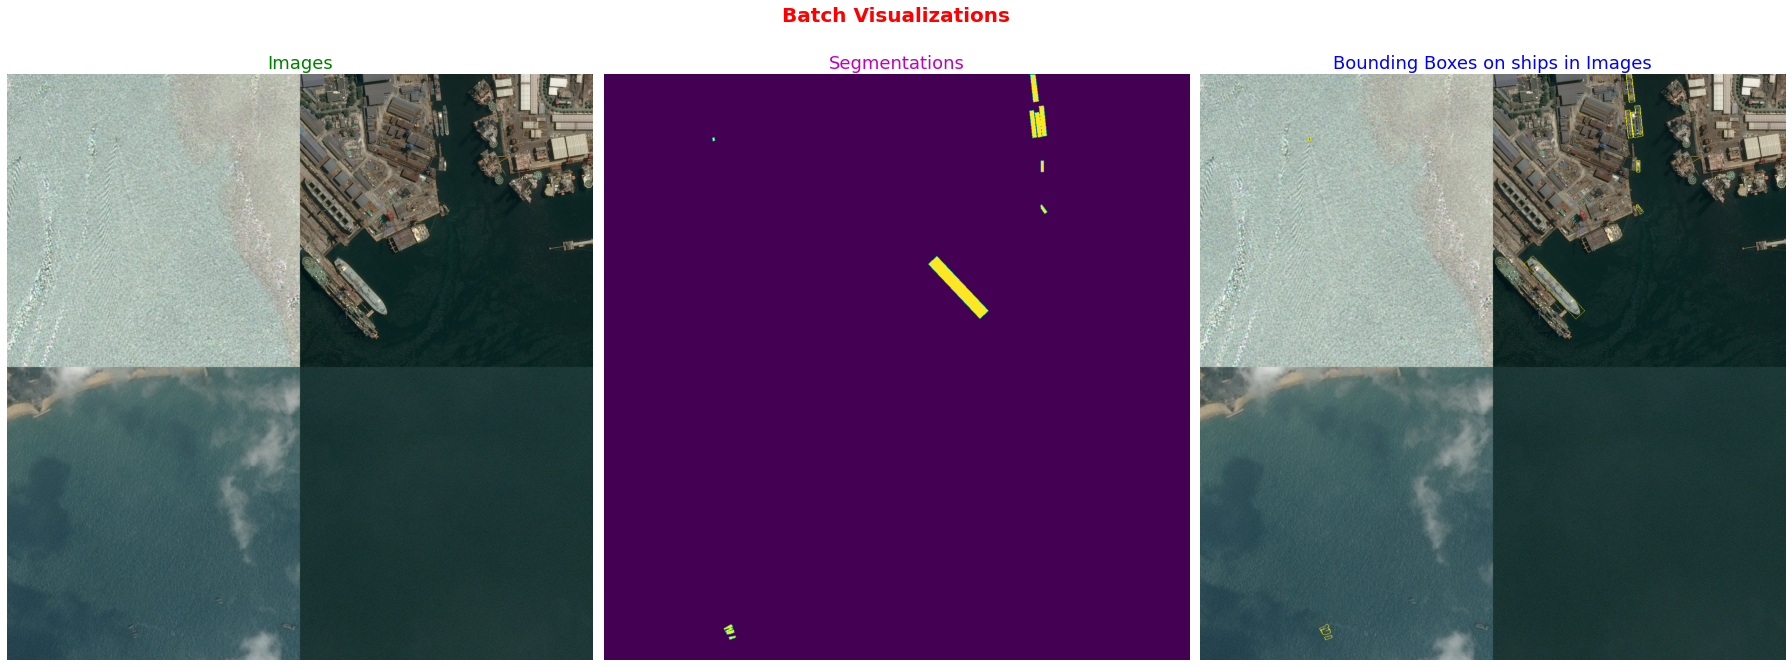

In [45]:
# Visulaising train batch
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
batch_rgb = montage_rgb(train_x)                                                   # Create montage of img
batch_seg = montage(train_y[:, :, :, 0])                                           # Create montafe of msk
batch_overlap = mark_boundaries(batch_rgb, batch_seg.astype(int))                  # Create bounding box around ships in img
titles = ["Images", "Segmentations", "Bounding Boxes on ships in Images"]          # Titles for subplot
colors = ['g', 'm', 'b']                                                           # Colors to be used for title
display = [batch_rgb, batch_seg, batch_overlap]                                    # What to display in subplot
plt.figure(figsize=(25,10))                                                        # Generate figure 
for i in range(3):                                                                 # For i = 0, 1, 2, 3                           
    plt.subplot(1, 3, i+1)                                                         # Create subplot
    plt.imshow(display[i])                                                         # Display 
    plt.title(titles[i], fontsize = 18, color = colors[i])                         # Title 
    plt.axis('off')                                                                # Turn off the axis
plt.suptitle("Batch Visualizations", fontsize = 20, color = 'r', weight = 'bold')  # Add suptitle
plt.tight_layout()                                                                 # Layout for subplot

In [46]:
# Prepare validation data
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(f"valid_x ~\nShape: {valid_x.shape}\nMin value: {valid_x.min()}\nMax value: {valid_x.max()}")
print(f"\nvalid_y ~\nShape: {valid_y.shape}\nMin value: {valid_y.min()}\nMax value: {valid_y.max()}")

valid_x ~
Shape: (400, 768, 768, 3)
Min value: 0.0
Max value: 1.0

valid_y ~
Shape: (400, 768, 768, 1)
Min value: 0
Max value: 1


In [47]:
# Augmenting Data using ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

# Preparing image data generator arguments
dg_args = dict(rotation_range = 15,            # Degree range for random rotations
               horizontal_flip = True,         # Randomly flips the inputs horizontally
               vertical_flip = True,           # Randomly flips the inputs vertically
               data_format = 'channels_last')  # channels_last refer to (batch, height, width, channels)

- Click [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to find more information on ImageDataGenerator and its arguments.

In [48]:
image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    '''
    Takes in -
    in_gen - train data generator, seed value
    '''
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))  # Randomly assign seed value if not provided
    for in_x, in_y in in_gen:                                                    # For imgs and msks in train data generator
        seed = 12                                                                # Seed value for imgs and msks must be same else augmentation won't be same
        
        # Create augmented imgs
        g_x = image_gen.flow(255*in_x,                                           # Inverse scaling on imgs for augmentation                                       
                             batch_size = in_x.shape[0],                         # batch_size = 3
                             seed = seed,                                        # Seed
                             shuffle=True)                                       # Shuffle the data
        
        # Create augmented masks
        g_y = label_gen.flow(in_y,
                             batch_size = in_x.shape[0],                       
                             seed = seed,                                         
                             shuffle=True)                                       
        
        '''Yeilds - augmented scaled imgs and msks array'''
        yield next(g_x)/255.0, next(g_y)

In [49]:
# Augment the train data
cur_gen = create_aug_gen(train_gen, seed = 42)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


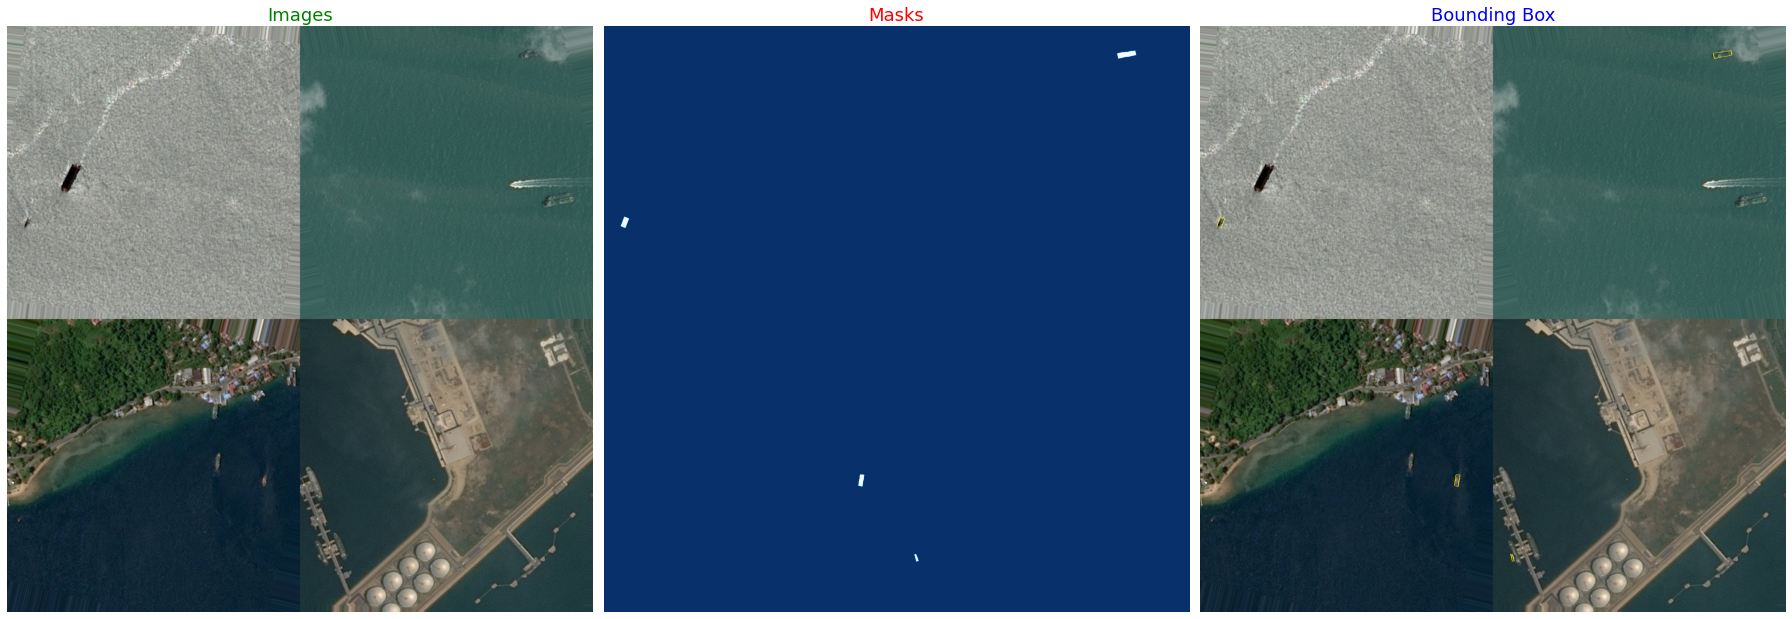

In [50]:
# Final display before passing data into model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (25, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('Images', fontsize = 18, color = 'g')
ax1.axis('off')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='Blues_r')
ax2.set_title('Masks', fontsize = 18, color = 'r')
ax2.axis('off')
ax3.imshow(mark_boundaries(montage_rgb(t_x), montage(t_y[:, :, :, 0].astype(int))))
ax3.set_title('Bounding Box', fontsize = 18, color = 'b')
ax3.axis('off')
plt.tight_layout()

In [51]:
gc.collect() # Block all the garbage that has been generated

75

## A brief introduction on U-NET architecture <a class="anchor"  id="h6"></a>

<img src="https://miro.medium.com/max/720/1*f7YOaE4TWubwaFF7Z1fzNw.png" width = 60%>

- The name U-NET itself is due to the shape of its architecture.
- Each blue box corresponds to a multi-channel feature map.
- The number of channels are denoted on top of the box.
- The x-y size is provided at the lower left edge of the box.
- The arrows shows the respective operations as mentioned on the bottom right of the image.
- This architecture consists of three sections: The contraction, The bottleneck, and the expansion section. 
- But the heart of this architecture lies in the expansion section. 
- This action would ensure that the features that are learned while contracting the image will be used to reconstruct it.

*For in-depth understanding do read this amazing [line by line explanation](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5).*

## Building and Training U-NET from Scratch <a class="anchor"  id="h7"></a>

<img src = "https://i.stack.imgur.com/o5TBk.png" width = 45%>       

<img src = "https://www.researchgate.net/publication/333593451/figure/fig2/AS:765890261966848@1559613876098/Illustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max.png" width = 45% height = 30%>

In [52]:
# Build U-Net model
from keras import models, layers

# Conv2DTranspose upsampling
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
# Upsampling without Conv2DTranspose
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

# Upsampling method choice
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple

# Building the layers of UNET
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

# If NET_SCALING is defined then do the next step else continue ahead
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)

# To avoid overfitting and fastening the process of training
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)                       # Useful to mitigate overfitting
pp_in_layer = layers.BatchNormalization()(pp_in_layer)                                # Allows using higher learning rate without causing problems with gradients


## Downsample (C-->C-->MP)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

## Upsample (U --> Concat --> C --> C)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)

if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])

seg_model.summary()

2022-10-17 21:36:12.674625: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 768, 768, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 768, 768, 3)  12          gaussian_noise[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 768, 768, 8)  224         batch_normalization[0][0]        
______________________________________________________________________________________________

#### Calculating the output shape of the feature map depending on strides, kernel size, input size, padding

<img src = "https://i.stack.imgur.com/qPKxm.png" width = 45%>

#### Metric and Loss for compiling the model

**Dice Coeffiient:-**        
<img src = "https://cdn-images-1.medium.com/max/1600/0*HuENmnLgplFLg7Xv" width = 45%>

<img src = "https://drive.google.com/uc?id=1XoP-1kwuScIj2Ee7rYrARylF8DRyJDF6" width = 45%>       

<img src = "https://pbs.twimg.com/media/FBmVmdHWQAAU7gq.png" width = 45% height = 20%>

<img src = "https://drive.google.com/uc?id=1oFWisqT_z0AKXvp1-JQ3LSjcwWrxjz2J" width = 45%>


*[Here](https://arxiv.org/pdf/2006.14822.pdf), you can find a survey of Loss functions for semantic segmentations.*        
*More info can be found [here](https://www2.cs.sfu.ca/~hamarneh/ecopy/cmig2019.pdf)*

In [53]:
# Compute dice coefficient, loss with BCE and compile the model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy

# Dice coeff
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3]  )                         # int = y_true ∩ y_pred
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])           # un = y_true_flatten ed ∪ y_pred_flattened
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)     # dice = 2 * int + 1 / un + 1

# Dice with BCE
def dice_p_bce(y_true, y_pred):
    '''
    Compute this function based on the explanation
    - use alpha = 1e-3
    '''
    
    combo_loss = "Something"
         
    return combo_loss

# Compile the model
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef])

In [54]:
# Preparing Callbacks 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Best model weights
weight_path="{}_weights.best.hdf5".format('seg_model')

# Monitor validation dice coeff and save the best model weights
checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

# Reduce Learning Rate on Plateau
reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)

# Stop training once there is no improvement seen in the model
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited

# Callbacks ready
callbacks_list = [checkpoint, early, reduceLROnPlat]

- *Just in case you are not aware about callbacks we use in keras you can learn more about it [here](https://keras.io/api/callbacks/).*

In [ ]:
# Finalizing steps per epoch
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)

# Final augmented data being used in training
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))

# Save loss history while training
loss_history = [seg_model.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks_list,
                            workers=1)] 

In [ ]:
# Save the weights to load it later for test data 
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')